In [0]:
!pip install -q keras

In [0]:
import pandas as pd
import numpy as np 
import keras
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [0]:
features = pd.read_csv("features(1).csv")
dam_prices = pd.read_csv("dam_prices(1).csv")
rt_prices = pd.read_csv("rt_prices(1).csv")

In [0]:
rt_prices.head()

,dates,SMECO_RESID_AGG..RTLMP..Average,DOM_RESID_AGG..RTLMP..Average,AEPKY_RESID_AGG..RTLMP..Average
0,2018-01-28 01:00:00,22.02,21.98,21.98
1,2018-01-28 02:00:00,21.68,21.64,21.66
2,2018-01-28 03:00:00,21.13,21.12,21.21
3,2018-01-28 04:00:00,21.22,21.23,21.39
4,2018-01-28 05:00:00,21.74,21.77,21.93


In [0]:
SMECO_RESID_AGG_dam = pd.concat([features, dam_prices["SMECO_RESID_AGG..DALMP..Average"]], axis = 1)
SMECO_RESID_AGG_rt = pd.concat([features, rt_prices["SMECO_RESID_AGG..RTLMP..Average"]], axis = 1)


## Partial autocorrelation analysis

We need to figure out how to shape the matrix. We need batch size, time steps and features. Batch size will be 24 for a 24h weight update, features are the features we have avalaible (11) and time steps we have to figure out. A autocorrelation analysis will help us figure out how many time steps we should get. 

In [0]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

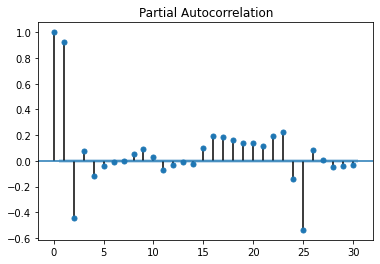

In [0]:
plot_pacf(dam_prices["SMECO_RESID_AGG..DALMP..Average"], lags=30)
pyplot.show()

Here we see that for this node, the partial autocorrelation is more or less significative for the first 25 lags

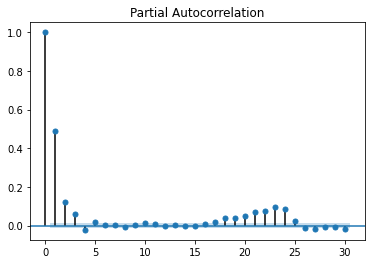

In [0]:
plot_pacf(rt_prices["SMECO_RESID_AGG..RTLMP..Average"], lags=30)
pyplot.show()

Here, we can see that the partial autocorrelation stays significaitve for the first 4 lags. 

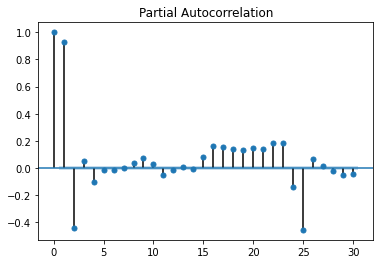

In [0]:
plot_pacf(dam_prices["DOM_RESID_AGG..DALMP..Average"], lags=30)
pyplot.show()

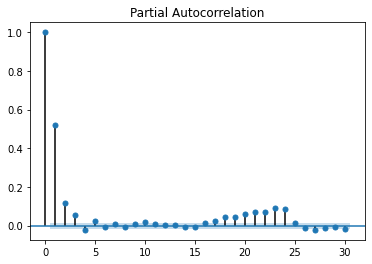

In [0]:
plot_pacf(rt_prices["DOM_RESID_AGG..RTLMP..Average"], lags=30)
pyplot.show()

So the time steps composant of the input matrix will be 25 for the dam models and 4 for the real time models

## Normalizing the data and creating test and train sets.

There are two ways to normalize the data, with MaxMinScaler and StandardScaler. Serveral exemples I found on the internet use the MinMaxScaler, I have tendency to use the StandardScaler and a tanh function in the first layer, so I avoid compressing my outliers. 

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [0]:
print(SMECO_RESID_AGG_dam.columns[10])

SMECO_RESID_AGG..DALMP..Average


In [0]:
def Split_and_Norm(df, train_size=0.8, test_size=0.2):
  
  df_train, df_test = train_test_split(df, train_size=train_size, test_size=test_size, shuffle=False)
  # scale the feature MinMax, build array
  total_cols = len(df.columns)
  _cols = df.columns[1:total_cols]
  x = df_train.loc[:, _cols].values
  y = df_test.loc[:, _cols].values
  standard_scaler = MinMaxScaler()
  x_train = x
  x_test = y
  x_train[:, :total_cols-2] = standard_scaler.fit_transform(x[:, :total_cols-2])
  x_test[:, :total_cols-2] = standard_scaler.transform(y[:, :total_cols-2])

  return(x_train, x_test)


In [0]:
SMECO_dam_train, SMECO_dam_test = Split_and_Norm(SMECO_RESID_AGG_dam)
SMECO_rt_train, SMECO_rt_test = Split_and_Norm(SMECO_RESID_AGG_rt, 0.7, 0.3)

DOM_dam_train, DOM_dam_test = Split_and_Norm(DOM_RESID_AGG_dam)
DOM_rt_train, DOM_rt_test = Split_and_Norm(DOM_RESID_AGG_rt)

AEPKY_dam_train, AEPKY_dam_test = Split_and_Norm(AEPKY_RESID_AGG_dam)
AEPKY_rt_train, AEPKY_rt_test = Split_and_Norm(AEPKY_RESID_AGG_rt)

In [0]:
SMECO_RESID_AGG_rt.head()

,dates,Gas.price,MidAtl_Pool_pr,western_Pool_prev,Total_Pool_prev,Percent.diff.MidAtl_Pool_pr,Percent.diff.western_Pool_prev,Percent.diff.Total_Pool_prev,PJM.POOL.J2,MISO_POOL_J2,SMECO_RESID_AGG..RTLMP..Average
0,1/28/2018 1:00,3.1,27860.0,42874.0,80540.0,-0.047554,-0.045293,-0.048957,2011.0,4258.0,22.02
1,1/28/2018 2:00,3.1,26049.0,41410.0,76483.0,-0.065004,-0.034147,-0.050372,1719.0,4040.0,21.68
2,1/28/2018 3:00,3.1,25135.0,40372.0,74227.0,-0.035088,-0.025066,-0.029497,1826.0,3747.0,21.13
3,1/28/2018 4:00,3.1,24647.0,39719.0,72922.0,-0.019415,-0.016175,-0.017581,1733.0,3651.0,21.22
4,1/28/2018 5:00,3.1,24458.0,39502.0,72509.0,-0.007668,-0.005463,-0.005664,1460.0,3543.0,21.74


In [0]:
for i in range(10):
  print(SMECO_rt_train[:,i].min(), SMECO_rt_train[:,i].max())

0.0 0.9999999999999999
0.0 1.0
0.0 1.0
0.0 1.0000000000000002
0.0 1.0
0.0 1.0
0.0 0.9999999999999999
0.0 1.0
0.0 1.0
-53.08 696.5


In [0]:
SMECO_dam_test[:10, -1]

array([26.32, 30.05, 35.67, 36.49, 37.29, 42.4 , 43.91, 47.39, 43.66,
       38.09])

# SMECO_RESID_AGG

## DAM Model

### Building the input matrix


In [0]:
BATCH_SIZE = 32
TIME_STEPS = 25
lr = 0.001


In [0]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [0]:
def build_timeseries(mat, y_col_index,TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [0]:
SMECO_dam_train.shape

(13496, 10)

In [0]:
SMECO_dam_x, SMECO_dam_y = build_timeseries(SMECO_dam_train,9, TIME_STEPS)

# SMECO_dam_x = trim_dataset(SMECO_dam_x, BATCH_SIZE)
# SMECO_dam_y = trim_dataset(SMECO_dam_y, BATCH_SIZE)

length of time-series i/o (13471, 25, 10) (13471,)


In [0]:
x_test, y_test = build_timeseries(SMECO_dam_test, 9,TIME_STEPS)

# SMECO_dam_x_val, SMECO_dam_x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
# SMECO_dam_y_val, SMECO_dam_y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (3350, 25, 10) (3350,)


In [0]:
print(sum(SMECO_dam_y<0))
print(sum(y_test<0))

0
0


### Building model

In [0]:
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Input, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras import callbacks

In [0]:
d1, d2, d3 = SMECO_dam_x.shape

In [0]:
# SMECO_dam_x = np.expand_dims(SMECO_dam_x, 1)
#np.reshape(SMECO_dam_x,(d1,d3,d4)) 
SMECO_dam_x.shape

(13471, 25, 10)

In [0]:
def root_mean_squared_error(y_true, y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true), axis=-1)) 

In [0]:
#MSE

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(TIME_STEPS, SMECO_dam_x.shape[-1])))

model.add(Flatten())

model.add(Dense(60, activation='relu'))
model.add(Dense(50, activation='relu'))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics='mean_squared_error')


In [0]:
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1, restore_best_weights=True)


history = model.fit(SMECO_dam_x, SMECO_dam_y, epochs=100, verbose=1, batch_size=BATCH_SIZE,
                    shuffle=False, validation_split=0.2, callbacks=[es])

Epoch 1/100
337/337 [==============================] - 1s 4ms/step - loss: 67.1488 - mean_squared_error: 67.1894 - val_loss: 31.4665 - val_mean_squared_error: 31.6462
Epoch 2/100
337/337 [==============================] - 1s 3ms/step - loss: 24.6459 - mean_squared_error: 24.6592 - val_loss: 15.8185 - val_mean_squared_error: 15.8899
Epoch 3/100
337/337 [==============================] - 1s 3ms/step - loss: 15.2280 - mean_squared_error: 15.2359 - val_loss: 6.9545 - val_mean_squared_error: 6.9972
Epoch 4/100
337/337 [==============================] - 1s 3ms/step - loss: 13.3517 - mean_squared_error: 13.3582 - val_loss: 6.4214 - val_mean_squared_error: 6.4665
Epoch 5/100
337/337 [==============================] - 1s 3ms/step - loss: 13.6133 - mean_squared_error: 13.6200 - val_loss: 7.3716 - val_mean_squared_error: 7.4207
Epoch 6/100
337/337 [==============================] - 1s 3ms/step - loss: 12.7441 - mean_squared_error: 12.7504 - val_loss: 6.6229 - val_mean_squared_error: 6.6740
Epoch 

In [0]:
model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

105/105 [==============================] - 0s 1ms/step - loss: 6.5247 - mean_squared_error: 6.5415


[6.524724006652832, 6.541470527648926]

In [0]:
print("[INFO] Making predictions...")
preds = model.predict(x_test)

diff = preds.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print(f'mean: {mean}\t std: {std}')

[INFO] Making predictions...
mean: 4.960911237816385	 std: 6.391817983209432


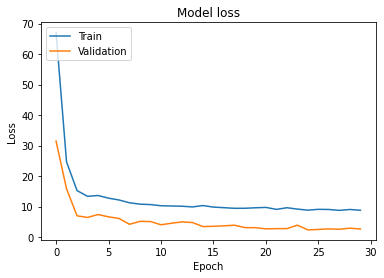

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
#MAE

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(TIME_STEPS, SMECO_dam_x.shape[-1])))

model.add(Flatten())

model.add(Dense(60, activation='relu'))
model.add(Dense(50, activation='relu'))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')


In [0]:
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1, restore_best_weights=True)


history = model.fit(SMECO_dam_x, SMECO_dam_y, epochs=100, verbose=1, batch_size=BATCH_SIZE,
                    shuffle=False, validation_split=0.2, callbacks=[es])

Epoch 1/100
337/337 [==============================] - 1s 3ms/step - loss: 62.5641 - val_loss: 26.7703
Epoch 2/100
337/337 [==============================] - 1s 3ms/step - loss: 16.6477 - val_loss: 8.8720
Epoch 3/100
337/337 [==============================] - 1s 3ms/step - loss: 13.5198 - val_loss: 6.3898
Epoch 4/100
337/337 [==============================] - 1s 3ms/step - loss: 13.4227 - val_loss: 7.2406
Epoch 5/100
337/337 [==============================] - 1s 3ms/step - loss: 13.0717 - val_loss: 6.9644
Epoch 6/100
337/337 [==============================] - 1s 3ms/step - loss: 12.2148 - val_loss: 6.0969
Epoch 7/100
337/337 [==============================] - 1s 3ms/step - loss: 11.4644 - val_loss: 6.1974
Epoch 8/100
337/337 [==============================] - 1s 3ms/step - loss: 10.5767 - val_loss: 3.8957
Epoch 9/100
337/337 [==============================] - 1s 3ms/step - loss: 10.8259 - val_loss: 6.7407
Epoch 10/100
337/337 [==============================] - 1s 3ms/step - loss: 10.41

In [0]:
model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

105/105 [==============================] - 0s 2ms/step - loss: 9.0435


9.043460845947266

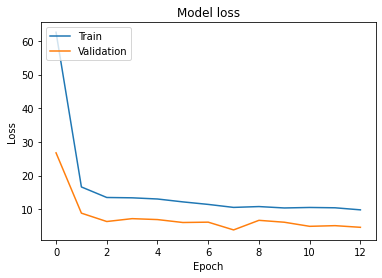

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Text(0, 0.5, 'Real prices ($/MW)')

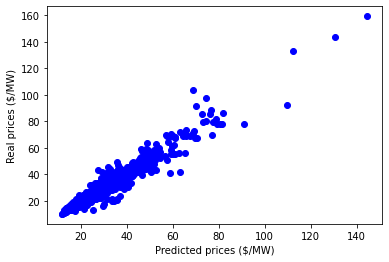

In [0]:
#@title Default title text
plt.plot(preds, y_test ,"bo")
plt.xlabel("Predicted prices ($/MW)")
plt.ylabel("Real prices ($/MW)")

## DRT Model

### Building the input matrix


In [0]:
BATCH_SIZE = 32
TIME_STEPS = 25
lr = 0.001

In [0]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [0]:
def build_timeseries(mat, y_col_index,TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [0]:
SMECO_rt_train.shape

(11809, 10)

In [0]:
SMECO_rt_x, SMECO_rt_y = build_timeseries(SMECO_rt_train,9, TIME_STEPS)


length of time-series i/o (11784, 25, 10) (11784,)


In [0]:
x_test_rt, y_test_rt = build_timeseries(SMECO_rt_test, 9,TIME_STEPS)

# SMECO_dam_x_val, SMECO_dam_x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
# SMECO_dam_y_val, SMECO_dam_y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (5037, 25, 10) (5037,)


std:  32.27729582225268


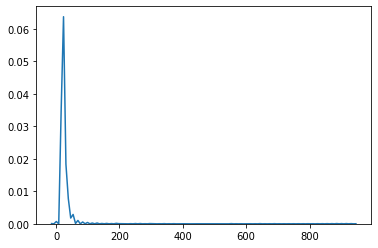

In [0]:
sns.distplot(y_test_rt, hist=False); print("std: " ,y_test_rt.std())

std:  20.70079188894433


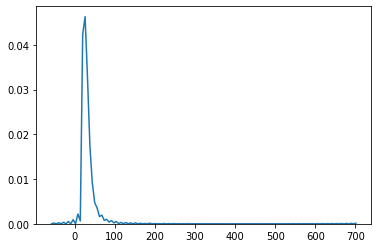

In [0]:
sns.distplot(SMECO_rt_y,hist=False); print("std: ", SMECO_rt_y.std())

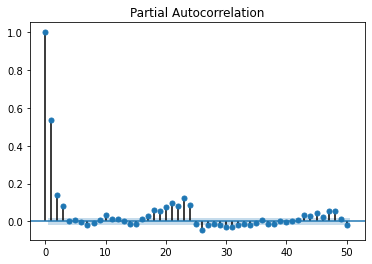

In [0]:
plot_pacf(SMECO_rt_y, lags=50)
pyplot.show()

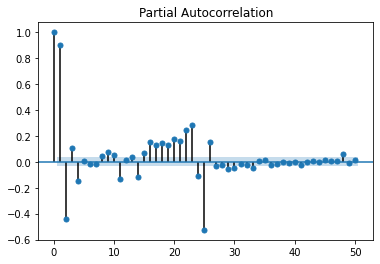

In [0]:
plot_pacf(y_test, lags=50)
pyplot.show()

In [0]:
print(SMECO_rt_y.std())
print(y_test_rt.std())

20.70079188894433
32.27729582225268


In [0]:
# SMECO_dam_x = np.expand_dims(SMECO_dam_x, 1)
#np.reshape(SMECO_dam_x,(d1,d3,d4)) 
print(sum(SMECO_rt_y<0))
print(sum(y_test_rt<0))

5
1


### Building model

In [0]:
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Input, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras import callbacks

In [0]:
d1, d2, d3 = SMECO_rt_x.shape

In [0]:

#MSE
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=1, activation='relu', input_shape=(TIME_STEPS, SMECO_rt_x.shape[-1])))
model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))

model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')



In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 25, 256)           2816      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 24, 256)           131328    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 23, 128)           65664     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 22, 64)            16448     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 21, 64)            8256      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 20, 128)           16512     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 128)          

In [0]:
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1, restore_best_weights=True)


history = model.fit(SMECO_rt_x, SMECO_rt_y, epochs=100, verbose=1, batch_size=BATCH_SIZE,
                    shuffle=False, validation_split=0.2, callbacks=[es])

Epoch 1/100
295/295 [==============================] - 12s 40ms/step - loss: 455.7953 - val_loss: 421.6758
Epoch 2/100
295/295 [==============================] - 12s 40ms/step - loss: 349.1546 - val_loss: 410.5308
Epoch 3/100
295/295 [==============================] - 12s 39ms/step - loss: 314.4267 - val_loss: 409.6924
Epoch 4/100
295/295 [==============================] - 12s 39ms/step - loss: 311.3252 - val_loss: 403.0567
Epoch 5/100
295/295 [==============================] - 11s 39ms/step - loss: 298.3528 - val_loss: 389.4853
Epoch 6/100
295/295 [==============================] - 12s 39ms/step - loss: 302.4679 - val_loss: 382.1679
Epoch 7/100
295/295 [==============================] - 12s 39ms/step - loss: 293.3589 - val_loss: 380.5492
Epoch 8/100
295/295 [==============================] - 12s 39ms/step - loss: 286.2781 - val_loss: 389.5070
Epoch 9/100
295/295 [==============================] - 12s 40ms/step - loss: 294.5381 - val_loss: 378.8130
Epoch 10/100
295/295 [===============

In [0]:
model.evaluate(x_test_rt, y_test_rt, batch_size=BATCH_SIZE)

158/158 [==============================] - 1s 9ms/step - loss: 870.7702


870.7702026367188

In [0]:
print("[INFO] Making predictions...")
preds = model.predict(x_test_rt)

diff = preds.flatten() - y_test_rt
percentDiff = (diff / y_test_rt) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print(f'mean diff: {mean}\t diff std: {std}')

[INFO] Making predictions...
mean diff: 23.178980918728396	 diff std: 26.063757439502375


In [0]:
#MAE
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=1, activation='relu', input_shape=(TIME_STEPS, SMECO_rt_x.shape[-1])))
model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))

model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 25, 256)           2816      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 24, 256)           131328    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 23, 128)           65664     
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 22, 64)            16448     
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 21, 64)            8256      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 20, 128)           16512     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)          

In [0]:
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1, restore_best_weights=True)


history = model.fit(SMECO_rt_x, SMECO_rt_y, epochs=100, verbose=1, batch_size=BATCH_SIZE,
                    shuffle=False, validation_split=0.2, callbacks=[es])

Epoch 1/100
295/295 [==============================] - 12s 41ms/step - loss: 10.7800 - val_loss: 6.5771
Epoch 2/100
295/295 [==============================] - 12s 41ms/step - loss: 8.8303 - val_loss: 5.3642
Epoch 3/100
295/295 [==============================] - 12s 41ms/step - loss: 8.0902 - val_loss: 5.2321
Epoch 4/100
295/295 [==============================] - 12s 42ms/step - loss: 7.9057 - val_loss: 5.2469
Epoch 5/100
295/295 [==============================] - 12s 41ms/step - loss: 7.7798 - val_loss: 5.7326
Epoch 6/100
295/295 [==============================] - 12s 40ms/step - loss: 7.7400 - val_loss: 5.6942
Epoch 7/100
295/295 [==============================] - 12s 41ms/step - loss: 7.7778 - val_loss: 6.2394
Epoch 8/100
295/295 [==============================] - 12s 41ms/step - loss: 7.5751 - val_loss: 5.6945
Epoch 00008: early stopping


In [0]:
model.evaluate(x_test_rt, y_test_rt, batch_size=BATCH_SIZE)

158/158 [==============================] - 1s 9ms/step - loss: 8.4789


8.478857040405273

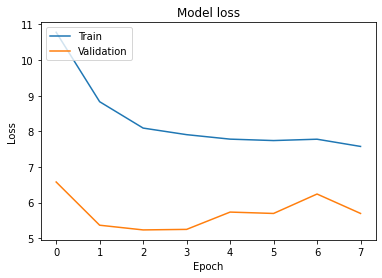

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Text(0, 0.5, 'Real prices ($/MW)')

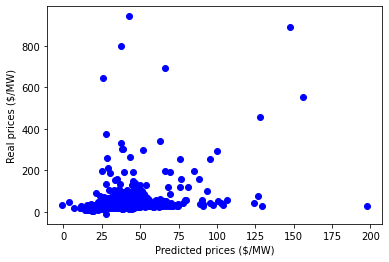

In [0]:
plt.plot(preds, y_test_rt ,"bo")
plt.xlabel("Predicted prices ($/MW)")
plt.ylabel("Real prices ($/MW)")

As you can see that traditionally CNNs do not perform well on time-series problems.